In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud

In [2]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df[["v1", "v2"]]

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.rename(columns = {
    "v1": "label",
    "v2": "text"
}, inplace=True)

In [7]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


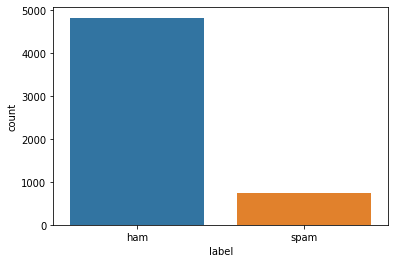

In [8]:
sns.countplot(df['label'])
plt.show()

In [9]:
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )

In [10]:
df_ham = df[df["label"] == 0]

In [11]:
df_spam = df[df["label"] == 1]

In [12]:
def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

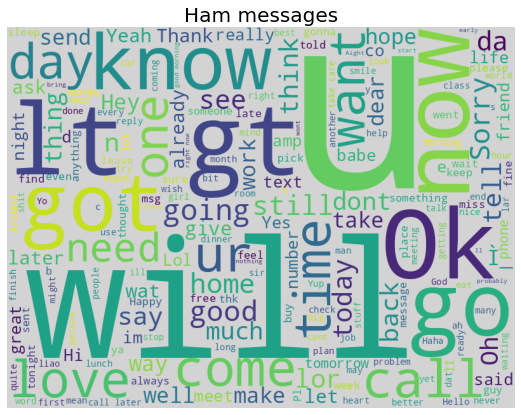

In [13]:
show_wordcloud(df_ham, "Ham messages")

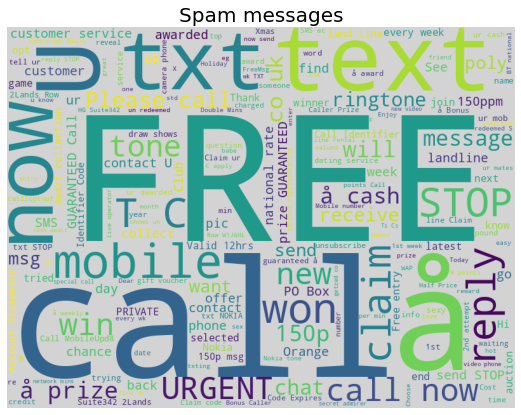

In [14]:
show_wordcloud(df_spam, "Spam messages")

In [15]:
X = df['text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [17]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [20]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[ 322   10   53 ...   30  349 1990]
 [1992 2558   21 ...  203 1025  225]
 [  83 1443    4 ...    2 3794 3795]
 ...
 [1477   30 2063 ...  239   30 2064]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...    8  290  175]]


In [21]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 24)             190920    
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               96500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1895 - accuracy: 0.9224 - val_loss: 0.1249 - val_accuracy: 0.9758
Epoch 2/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0895 - val_accuracy: 0.9821
Epoch 3/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.1172 - val_accuracy: 0.9794
Epoch 4/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.2254 - val_accuracy: 0.9803
Epoch 5/50
140/140 [==============================] - 0s 2ms/step - loss: 6.1245e-05 - accuracy: 1.0000 - val_loss: 0.2578 - val_accuracy: 0.9830
Epoch 6/50
140/140 [==============================] - 0s 2ms/step - loss: 5.2962e-08 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9830
Epoch 7/50
140/140 [==============================] - 0s 2ms/step - loss: 6.2149e-09 - accuracy: 1.0000 - val_loss: 0.3079 - val_accuracy: 0

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    return acc_sc

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [26]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9811659192825112


0.9811659192825112

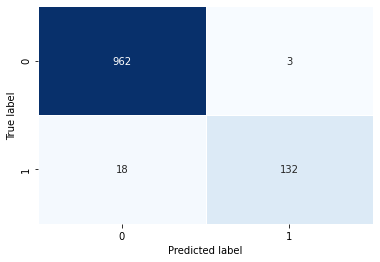

In [27]:
plot_confusion_matrix(y_test, preds)

In [28]:
model.save("spam_model")

INFO:tensorflow:Assets written to: spam_model/assets


In [29]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
    pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [30]:
s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as _input:
    tokenizer = pickle.load(_input)

In [48]:
def load_model(path="spam_model"):
    """
    This method loads the model from the local storage and return it as a tokenizer
    """
    s_model = tf.keras.models.load_model("spam_model")
    with open('spam_model/tokenizer.pkl', 'rb') as _input:
        tokenizer = pickle.load(_input)
    
    return s_model, tokenizer

In [58]:
def process_sms(sms):
    '''
    Apply saved tokenizer to new sms text and returns processed data
    '''
    max_length = 8
#     sms = [sms]
    sms_proc = tokenizer.texts_to_sequences(sms)
    sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')

    return sms_proc

In [79]:
def predict_spam_or_ham(sms=None):
    if not isinstance(sms, (list, )):
        raise AssertionError("sms must be of type list")
    if not all(isinstance(elem, list) for elem in sms):
        raise AssertionError("items inside sms must be of type list")
    s_model, tokenizer = load_model()
    preds = []
    for item in sms:
        sms_proc = tokenizer.texts_to_sequences(item)
        sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
#         sms_proc = process_sms(item)
        pred = (s_model.predict(sms_proc) > 0.5).astype("int32").item()
        if pred == 1:
            result = (" ".join(item), "spam")
        if pred == 0:
            result = (" ".join(item), "ham")
        preds.append(result)
    
    return preds

In [69]:
sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (s_model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

1


In [77]:
sms_one = ["Hi, Adeoti. Please call me"]
sms_two = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]

In [80]:
predict_spam_or_ham([sms_one, sms_two])

[('Hi, Adeoti. Please call me', 'ham'),
 ('We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB ',
  'spam')]